# Using Markov transition matrices to generate trial configurations in Markov chain Monte Carlo simulations - The harmonic chain system, Free Energy

## Table of Contents
1. [Routines and dependencies](#Functions)
2. [Main](#Algorithms) <br />
    2.1 [Generate the sampling with Algorithm B](#GenSamp)  <br />
    2.2 [Sampling $X_{tMC}$](#XtMCSampling)<br />
3. [Figure 7 (c)](#Figures)<br />

## 1. Routines and dependencies <a name="Functions"></a>

Import dependencies.

In [1]:
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy as sp
import os
import errno
from pylab import show,hist,subplot,figure 
from numpy import linalg as nla
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from matplotlib import pyplot
from matplotlib import gridspec
import matplotlib.font_manager as font_manager
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from datetime import datetime

today =datetime.today().strftime('%Y%m%d')


# use latex for font rendering
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['text.usetex'] = True


Define the routines.

In [2]:
def prior_prob(x, sigma):
    """Return a float
    Compute the prior distribution \pi_0(x)
    """
    dim=np.shape(x)[0]
    idim=0
    prob=1.
    while(idim<dim):
        prob=prob*np.exp(-x[idim]*x[idim]/2./sigma[idim]/sigma[idim])
        idim=idim+1
    return prob

def sample_prior(sigma):
    """Return a ndim-dimensional array of floats
    Generate a random variable distributed as prior_prob(x) if Gaussian
    """
    dim=np.shape(sigma)[0]
    rMonVec=np.array([])
    idim=0
    while(idim<dim):
        rnd=np.random.rand(2)
        r=np.sqrt(-2.*np.log(1.-rnd[0]))*sigma[idim]
        x=np.cos(rnd[1]*2.*np.pi)*r
        rMonVec=np.append(rMonVec,x)
        idim=idim+1
    return rMonVec


def PT(rChainVec,sigma):
    """Return a float
    Compute the equilibrium distribution \pi(x)
    """
    dim=np.shape(rChainVec)[1]
    Ntot=np.shape(rChainVec)[0]
    PT = 1.0
    i = 1
    while i<Ntot:
        u = rChainVec[i,:]-rChainVec[i-1,:]
        idim=0
        while(idim<dim):
            PT*=np.exp(-u[idim]*u[idim]/2./sigma[idim]/sigma[idim])
            idim+=1
        i+=1
    return PT


def Ptarg(riminus1,ri,rend,im,Ntot,sigma): 
    """Return a float
    Compute the target distribution used in the tMC \pi_T(x)
    """
    u2 = rend-ri
    u1 = ri-riminus1
    NL = Ntot-im
    dim = np.shape(sigma)[0]
    idim = 0
    Ptarg = prior_prob(u1,sigma)
    while(idim<dim):
        Ptarg *= np.exp(-u2[idim]*u2[idim]/sigma[idim]/sigma[idim]/2./NL)
        idim=idim+1
    return Ptarg

def acc(ximinus1,x,y,xend,im,Ntot,sigma):
    """Return two floats

    Compute the acceptance acc(x->y) using Metropolis or Heat-bath method
    Return 1) Jxx = 1-acc(x->y), 2) Jxx = acc(x->y)
    """
    Pnew=Ptarg(ximinus1,y,xend,im,Ntot,sigma)
    Pold=Ptarg(ximinus1,x,xend,im,Ntot,sigma)
#    print(Pnew, Pold)
#    Metropolis
#    if(Pnew>Pold):
#        Jxy=1.
#    else:
#        Jxy=Pnew/Pold    
    # Heat-bath
    Jxy=Pnew/(Pnew+Pold)
    Jxx=1.-Jxy  
    return Jxx, Jxy

def f(ximinus1,x,y,xend,px,py,Dx,im,Ntot,sigma):
    """Return three floats and one integer
    Configuration at layer i+1: y (=x+Dx)
    Configurations at layer i: y and x (prior prababilities py and px)
    The function samples between y and x at layer i
    Return: 1) the probability of y at layer i+1, 
            2) Jxy = acc(x->y),
            3) Jyy = 1-acc(y->y+Dx),
            4) new = 1 (0) if at layer i x (y) is selected
    """
    Jxx, Jxy = acc(ximinus1,x,y,xend,im,Ntot,sigma)
    z=y+Dx
    Jyy, Jyydx =acc(ximinus1,y,z,xend,im,Ntot,sigma)
    newpy=px*Jxy+py*Jyy
    rnd=np.random.rand(1)
    if(rnd[0]<px*Jxy/newpy):
        new=1
    else:
        new=0
    return newpy, Jxy, Jyy, new

def generate_dxVec(n,dxMax):
    """Return a (n,ndim)-dim array of floats
    The function generates the n displacements
    """    
    ndim=np.shape(dxMax)[0]
    idim=0
    r=np.array([])
    while(idim<ndim):
        r=np.append(r,dxMax[idim]*(2*np.random.rand(1)[0]-1.))
        idim+=1
    dxVec=r
    i_n=1
    while(i_n<n):
        idim=0
        r=np.array([])
        while(idim<ndim):
            r=np.append(r,dxMax[idim]*(2*np.random.rand(1)[0]-1.))
            idim+=1
        dxVec=np.vstack((dxVec,r))
        i_n+=1
    return dxVec

def generate_y(n,dxVec,ximinus1,xend,im,Ntot,sigma): 
    """Return an array of ndim floats, one float and an array of n integers
    The function generates a new optimized configuration y
    Return: 1) The new configuration y = y0 + VecEta_i * dxVec_i
            2) The generating probability  P_gen(y) = \pi_0(y_0)*\prod_{i=0}^{n-1}f(y_{i}->y_{i+1})
            3) The list of accepted/rejected moves {\eta}: 
                \eta_i = 1 (0) if the move y_{i} -> y_{i}+dxVec_i is accepted (rejected)
    """
    # The list of accepted/rejected moves {\eta}
    VecEta=np.array([])     
    u0=sample_prior(sigma)
    x=u0+ximinus1    
    
    # Initialise the probability of the trajectory
    prob=prior_prob(u0,sigma)
    ilayer=0
    while(ilayer<n):
        y=x+dxVec[ilayer,:]       
        # Compute the acceptance
        accxx, accxy = acc(ximinus1,x,y,xend,im,Ntot,sigma)
        rnd=np.random.rand(1)
        if(rnd[0]<accxy):
            x=deepcopy(y)
            prob=prob*accxy             
            VecEta=np.append(VecEta,1)
        else:
            prob=prob*accxx    
            VecEta=np.append(VecEta,0)           
        ilayer=ilayer+1    
    return x, prob, VecEta                

def regenerate_A(yn,n,dxVec,ximinus1,xend,VecEta,im,Ntot,sigma):     
    """Return a float
    Return the probability of the trajectory {dxVec, VecEta} ending in xn as used in Algorithm A
    """
    # Obtain the n+1 states of the trajectory (dxVec, eta) ending in xn
    ndim=np.shape(sigma)[0]
    Vec_x0=np.zeros((n+1,ndim))
    Vec_x0[n,:]=yn
    ip=n-1
    while(ip>=0):
        Vec_x0[ip,:]=Vec_x0[ip+1,:]-VecEta[ip]*dxVec[ip,:]
        ip=ip-1
    
    # Compute the probability of the trajectory 
    x0=Vec_x0[0,:]-ximinus1
    prob=prior_prob(x0,sigma) 
    ip=0
    while(ip<n):
        x=Vec_x0[ip,:]
        y=Vec_x0[ip,:]+dxVec[ip,:]
        Jyy, Jxy = acc(ximinus1,x,y,xend,im,Ntot,sigma)
        if(VecEta[ip] == 1):
            prob=prob*Jxy
        else:
            prob=prob*Jyy   
        ip=ip+1    
    return prob

def extractKBits(num,k,p):
    """Return an integer

    Extract ‘k’ bits at a given position 'p' of the binary representation of 'num'
    adapted from https://www.geeksforgeeks.org/python-slicing-extract-k-bits-given-position/
    """

    # convert number into binary first 
    binary = bin(num) 

    # remove first two characters 
    binary = binary[2:] 

    end = len(binary) - p 
    start = end - k + 1

    # extract k  bit sub-string 
    kBitSubStr = binary[start : end+1] 

    # convert extracted sub-string into decimal again 
    return int(kBitSubStr,2)
#     print (int(kBitSubStr,2))

def regenerate_B(yn,n,dxVec,ximinus1,xend,im,Ntot,sigma):     
    """Return one float:
    Compute the tree (or full) probability of yn or xn as used in Algorithm B
    """
    n2n=np.power(2,n)

    ndim=np.shape(sigma)[0]
    x0Vec=np.ones((n2n,ndim))

    x0Vec=yn
    ix0=0
    while(ix0<n2n):
        x0Vec=np.vstack((x0Vec,yn))
        ix0=ix0+1
  
    ix0=0
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=1
        while(ibit<n+1):
            acb=extractKBits(acn,1,ibit)            
            x0Vec[ix0,:]=x0Vec[ix0,:]-acb*dxVec[ibit-1,:]
            ibit=ibit+1
        ix0=ix0+1   
        
    # Running posteriori probabilities 
    piVec=np.zeros(n2n) 

    # Initialisation
    ix0=0
    while(ix0<n2n):
        x0ix0=x0Vec[ix0,:]-ximinus1
        piVec[ix0]=prior_prob(x0ix0,sigma)
        ix0=ix0+1
   
    ilayer=0
    while(ilayer<n):
        dnx=np.power(2,ilayer)
        dny=np.power(2,ilayer+1)
        ix0=0
        while(ix0<n2n):
            x=x0Vec[ix0+dnx,:]
            y=x0Vec[ix0,:]
            py=piVec[ix0]
            px=piVec[ix0+dnx]
            newpy, Jxy, Jyy, new = f(ximinus1,x,y,xend,px,py,dxVec[ilayer,:],im,Ntot,sigma)
            piVec[ix0]=newpy
            ix0=ix0+dny
            
        ilayer=ilayer+1

    return piVec[0]



def EtaMatrix(n):   
    n2n=np.power(2,n)
    ix0=0
    VecEtaMat=np.zeros((n2n,n))
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=n
        while(ibit>0):
            acb=extractKBits(acn,1,ibit)
            VecEtaMat[ix0,ibit-1]=acb
            ibit=ibit-1

        ix0=ix0+1
    return VecEtaMat

def DF(d,Nseg):
    """Return one float:
    Compute the difference in the free energy given in Eq. 31
    """
    return 0.5*np.power(d,2)/Nseg + 1.5*np.log(Nseg)


def binning(vv,bb): 
    rest=np.mod(np.shape(vv)[0],bb)
    if(rest !=0):
        vv_trimmed=vv[:-rest]
    else:
        vv_trimmed=vv
   
    ii=0
    while(ii<bb):

        index=np.arange(ii,np.shape(vv_trimmed)[0],bb)
        if(ii==0):
            vv_binned=vv_trimmed[index]
        else:
            vv_binned=vv_binned+vv_trimmed[index]
        ii+=1

    vv_binned=vv_binned/bb
   
    return vv_binned

## 2. Generate the samplings <a name="Algorithms"></a>

###### 2.1 Sampling the free energy with Algorithm B<a name="GenSamp"></a>

In [3]:
# Fig. 7(c) computation of Delta F with the tMC
# Algorithm B

n=10 # Number of iterations in the truncated Markov Chain (number of layers = n+1)
NMC=1e6 # Total number if Monte Carlo iterations
dxMax=np.array([2.0,2.0,2.0]) #/np.sqrt(n) # Maximal displacement
sigma=np.array([1.,1.,1.])
Ntot=3 # including the end monomers 

dd=0.

# Initialise the samplings of Delta F and the error on Delta F as function of the end-to-end distance
dDF_vs_d_array=np.array([]) # Delta F
DF_vs_d_array=np.array([]) # error on Delta F
d_array=np.array([])

name = 'HC_AlgoB_NMC=%g_n=%g_Ntot=%g' % (NMC,n,Ntot)


while(dd<40.):

    print('=========================')
    print('dd=',dd)
    accrate=0.

#   Initialization of the chain of monomers
    rChainVec=np.array([0.0,0.0,0.0])
    rstart=np.array([0.0,0.0,0.0])

    im=1
    while(im<Ntot-1):
        xi = np.array([im*dd/(Ntot-1),0.0,0.0])
        rChainVec=np.vstack((rChainVec,xi))
        im+=1
    rend=np.array([dd,0.0,0.0])
    rChainVec=np.vstack((rChainVec,rend))

    iMC=0

#   Sampling the statistics -  initialization
    Peq_new=np.array([])
    Peq_old=np.array([])
    PGen_new=np.array([])
    PGen_old=np.array([])
    
#   Sampling the free energy at given d -  initialization
    log_exp_mDF_array=np.array([]) # Sampling
    av_exp_mDF=0.0 # Average
    var_exp_mDF=0.0 # Variance
    cnt=0.

#   MCMC loop
    while iMC<NMC:
        probold=1.
        probnew=1.
        exp_mDF=1. # X_{tMC}
        imono=1 

        
#   Generating a trial of the chain of monomers
        rChainVecNew = np.array([0.,0.,0.])
        while imono<Ntot-1:

            dxVec=generate_dxVec(n,dxMax)

            if(imono>1):
                rm1=rChainVecNew[imono-1,:]
            else:
                rm1=rstart

            ri, probtrajnewi, VecEta = generate_y(n,dxVec,rm1,rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
            rChainVecNew = np.vstack((rChainVecNew,ri))     

            pnew_i=regenerate_B(rChainVecNew[imono,:],n,dxVec,rm1,rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
            probnew = probnew*pnew_i 
            exp_mDF = exp_mDF/pnew_i

            pold_i = regenerate_B(rChainVec[imono,:],n,dxVec,rChainVec[imono-1,:],rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
            probold = probold*pold_i

            imono+=1

        rChainVecNew = np.vstack((rChainVecNew,rend))


        Pnew = PT(rChainVecNew,sigma) 
        Pold = PT(rChainVec,sigma)
        exp_mDF = exp_mDF*Pnew #

        
#       Compute the free energy of the iteration
        av_exp_mDF+=exp_mDF
        var_exp_mDF+=exp_mDF*exp_mDF
        cnt+=1.0

        log_exp_mDF_array=np.append(log_exp_mDF_array,np.log(exp_mDF))

        
#       Sampling the statistics
        Peq_new=np.append(Peq_new,np.log(Pnew))
        Peq_old=np.append(Peq_old,np.log(Pold))
        PGen_new=np.append(PGen_new,np.log(probnew))
        PGen_old=np.append(PGen_old,np.log(probold))
        
        
#       Acceptance test        
    #Metropolis
        testacc = Pnew/Pold* probold/probnew 
        
    #Heat-Bath
#    testacc = Pnew*probold/(Pold*probnew + Pnew*probold)

        rnd = np.random.rand(1)
        if(rnd[0]<testacc):
            rChainVec=deepcopy(rChainVecNew)
            accrate=accrate+1.

        if(np.mod(iMC*10,NMC)==0):
            print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1.))
    
    
        iMC+=1

    print('Final acceptance rate:',accrate/NMC)   

#       Sample the free energy for f
    av_exp_mDF=av_exp_mDF/cnt
    var_exp_mDF=var_exp_mDF/cnt-av_exp_mDF*av_exp_mDF
    err_av_exp_mDF=np.power(var_exp_mDF/cnt,0.5)
    
    d_array=np.append(d_array, dd)
    DF_vs_d_array=np.append(DF_vs_d_array,np.log(av_exp_mDF))
    dDF_vs_d_array=np.append(dDF_vs_d_array,err_av_exp_mDF/np.abs(av_exp_mDF))    


    dd=dd+1.0



dd= 0.0
Number of iterations:  0 Acceptance rate: 0.0
Final acceptance rate: 0.0


In [ ]:
# Save the sampling
path = os.getcwd()
try:
    os.makedirs(path+'/data/')
    os.makedirs(path+'/plots/')
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(path):
        pass
    else: raise

np.save('data/'+name+'_DF_vs_d_array', DF_vs_d_array)
np.save('data/'+name+'_dDF_vs_d_array', dDF_vs_d_array)
np.save('data/'+name+'_dd_array', d_array)


### 2.2 Sampling $X_{tMC}$ <a name="XtMCSampling"></a>

In [5]:
# Fig. 7(c) - Inset :  distribution of X_{tMC} for a given end-to-end distance
# Algorithm B

n=10 # Number of iterations in the truncated Markov Chain (number of layers = n+1)
NMC=1e6 # Total number of Monte Carlo iterations
dxMax=np.array([2.0,2.0,2.0]) #/np.sqrt(n) # Maximal displacement
sigma=np.array([1.,1.,1.])
Ntot=6 # including the end monomers 

dd=20.# end-to-end distance 

name = 'HC_AlgoB_NMC=%g_n=%g_Ntot=%g_dd=%g' % (NMC,n,Ntot,dd)

accrate=0.

#   Initialization of the chain of monomers
rChainVec=np.array([0.0,0.0,0.0])
rstart=np.array([0.0,0.0,0.0])

im=1
while(im<Ntot-1):
    xi = np.array([im*dd/(Ntot-1),0.0,0.0])
    rChainVec=np.vstack((rChainVec,xi))
    im+=1
rend=np.array([dd,0.0,0.0])
rChainVec=np.vstack((rChainVec,rend))


iMC=0

#   Sampling the free energy and the equilibrium free energy - initialization
DF_array=np.array([])
DF_eq_array=np.array([])

#   MCMC loop
while iMC<NMC:


    probold=1.
    probnew=1.
    exp_mDF=1.
    exp_mDF_eq=1.
    imono=1 

    
#   Generate a trial  the chain of monomers
    rChainVecNew = np.array([0.,0.,0.])
    while imono<Ntot-1:

        dxVec=generate_dxVec(n,dxMax)

        if(imono>1):
            rm1=rChainVecNew[imono-1,:]
        else:
            rm1=rstart

        ri, probtrajnewi, VecEta = generate_y(n,dxVec,rm1,rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
        rChainVecNew = np.vstack((rChainVecNew,ri))     

        pnew_i=regenerate_B(rChainVecNew[imono,:],n,dxVec,rm1,rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
        probnew = probnew*pnew_i 
        exp_mDF = exp_mDF/pnew_i

        pold_i = regenerate_B(rChainVec[imono,:],n,dxVec,rChainVec[imono-1,:],rChainVec[Ntot-1,:],imono,Ntot-1,sigma)
        probold = probold*pold_i
        exp_mDF_eq = exp_mDF_eq/pold_i 

        imono+=1

    rChainVecNew = np.vstack((rChainVecNew,rend))

#   Compute the Delta F of the trial configuration
    Pnew = PT(rChainVecNew,sigma) 
    exp_mDF = exp_mDF * Pnew
    DF_array = np.append(DF_array, -np.log(exp_mDF))
    
#   Compute the Delta F of the current configuration
    Pold = PT(rChainVec,sigma)    
    exp_mDF_eq = exp_mDF_eq * Pold 
    
#       Acceptance test  
    #Metropolis
    testacc = Pnew/Pold* probold/probnew # * Jxnold / Jxnnew

    #Heat-Bath
#    testacc = Pnew*probold/(Pold*probnew + Pnew*probold)

    rnd = np.random.rand(1)
    if(rnd[0]<testacc):
            
        rChainVec=deepcopy(rChainVecNew)
        accrate=accrate+1.
        DF_eq_array = np.append(DF_eq_array , -np.log(exp_mDF))
    else :    
        DF_eq_array = np.append(DF_eq_array , -np.log(exp_mDF_eq))
                


    if(np.mod(iMC*10,NMC)==0):
         print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1.))
  
    iMC+=1

print('Final acceptance rate:',accrate/NMC)   


#   Sampling of X_{tMC} for the trial and the equilibrium configurations

hist_eq, edges_eq = np.histogram(DF_eq_array, bins=30, density=True)
hist, edges = np.histogram(DF_array, bins=30, density=True)

Number of iterations:  0 Acceptance rate: 0.0
Final acceptance rate: 0.0


In [ ]:
# Save the sampling
path = os.getcwd()
try:
    os.makedirs(path+'/data/')
    os.makedirs(path+'/plots/')
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(path):
        pass
    else: raise

np.save('data/'+name+'_hist_eq', hist_eq)
np.save('data/'+name+'_edge_eq', edge_eq)
np.save('data/'+name+'_hist', hist)
np.save('data/'+name+'_edge', edge)

## 3. Figure 7 (c) <a name="Figures"></a>

In [4]:
# Upload data

# CBMC free energy
f = open("data/HC_CBMC_dd_array.txt", "r")
dd_CBMC=np.array([])
for x in f:
    dd_CBMC=np.append(dd_CBMC, float(x))
f.close()

f = open("data/HC_CBMC_DF_array.txt", "r")
DF_CBMC=np.array([])
for x in f:
    DF_CBMC=np.append(DF_CBMC, float(x))
f.close()

f = open("data/HC_CBMC_dDF_array.txt", "r")
dDF_CBMC=np.array([])
for x in f:
    dDF_CBMC=np.append(dDF_CBMC, float(x))
f.close()

# CBMC sampling of X for dd=20
CBMC_new=np.loadtxt("data/HC_CBMC_X_c_trial.txt")
CBMC_eq=np.loadtxt("data/HC_CBMC_X_c.txt")

# tMC free energy
DF_array= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=5_DF_vs_d_array.npy',allow_pickle=True)
dDF_array= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=5_dDF_vs_d_array.npy',allow_pickle=True)
dd_array= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=5_dd_array.npy',allow_pickle=True)

# tMC sampling of X for dd=20
edges_eq= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=6_dd=20_edges_eq.npy',allow_pickle=True)
hist_eq= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=6_dd=20_hist_eq.npy',allow_pickle=True)
edges= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=6_dd=20_edges.npy',allow_pickle=True)
hist= np.load('data/HC_AlgoB_NMC=1000000_n=10_Ntot=6_dd=20_hist.npy',allow_pickle=True)


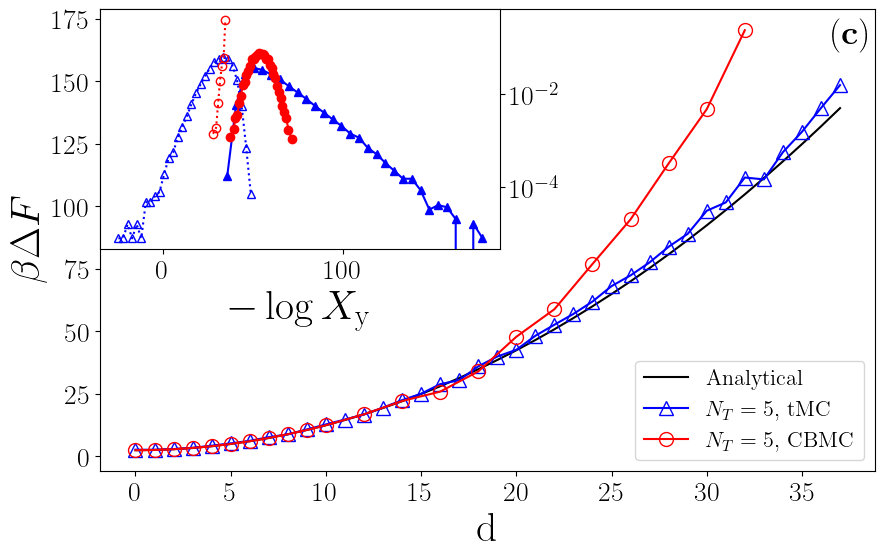

In [5]:
x_eq=(edges_eq[1:]+edges_eq[:-1])/2
x_n=(edges[1:]+edges[:-1])/2


CBMC_new_x=binning(CBMC_new[:,0],10)
CBMC_new_y=binning(CBMC_new[:,1],10)

CBMC_eq_x=binning(CBMC_eq[:,0],10)
CBMC_eq_y=binning(CBMC_eq[:,1],10)


fig, ax = plt.subplots(figsize=(10, 6))


DF_expected_array=DF(dd_array,5)

ax.plot(dd_array,DF_expected_array,'k-',label=r'Analytical')
ax.plot(dd_array, DF_array,linestyle = '-',marker='^',markersize=10, fillstyle='none', color ='b',label=r'$N_T=5$, tMC')
ax.plot(dd_CBMC,DF_CBMC,linestyle = '-',marker='o',markersize=10, fillstyle='none', color ='r',label=r'$N_T=5$, CBMC')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('d',fontsize=30)
ax.set_ylabel(r'$\beta \Delta F$',fontsize=30)
ax.text(36.6, 165, r'$(\mathrm{\bf c})$', fontsize=25)


pyplot.legend(fontsize=16,ncol=1,loc=4)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.125, 0.48, 0.4, 0.4]


ax2 = fig.add_axes([left, bottom, width, height])



ax2.set_xlabel(r'$-\log X_\mathrm{y}$',fontsize=30)
ax2.yaxis.set_ticks_position("right")

ax2.tick_params(axis='both', which='major', labelsize=20)

ax2.plot(x_eq,hist_eq,'^',linestyle = ':',fillstyle='none',color='blue')
ax2.plot(x_n,hist,'^',linestyle = '-',color='blue')

ax2.plot(CBMC_new_x,CBMC_new_y,'o',linestyle = '-',color='red')
ax2.plot(CBMC_eq_x,CBMC_eq_y,'o',linestyle = ':',fillstyle='none',color='red')

ax2.set_yscale("log")

plt.show()
